In [1]:
# install deps
# !pip install opencv-python matplotlib torch torchvision pycocotools scikit-learn segmentation-models-pytorch 
# cuda version of torch 
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


## 1. importar las librerias necesarias

In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"
os.environ["PROGRESS_DISABLE"] = "1"
os.environ["XET_DISABLE_PROGRESS"] = "1"
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1"

In [2]:
# native
import os 
import json
import numpy as np
import random
import time

# 3rd party
import cv2

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image, ImageDraw

from torchvision import transforms
from torchvision.transforms import v2
from torchmetrics.classification import MulticlassJaccardIndex
from torchmetrics.segmentation  import DiceScore

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim  as optim
from torch.utils.data import DataLoader, Dataset

from pycocotools.coco import COCO

from sklearn.model_selection import train_test_split

import segmentation_models_pytorch as smp


#  script 

import importlib
import scripts.fn as fn
importlib.reload(fn)


<module 'scripts.fn' from '/notebooks/scripts/fn.py'>

In [3]:
# cargar anotaciones coco
cloud = True

anot_path = "/notebooks/annotations_fixed.json"  if cloud else "C:/Users/madri/Documents/maia/proyecto 2/annotations_fixed.json"
img_dir = "/notebooks/imgs" if cloud else "C:/Users/madri/Documents/maia/proyecto 2/imgs"
# masks_dir = "C:/Users/madri/Documents/maia/proyecto 2/masks"

with open(anot_path) as f:
    data = json.load(f)

coco = COCO(anot_path)


print("Número de imágenes:", len(data['images']))
print("Número de anotaciones:", len(data['annotations']))


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
Número de imágenes: 168
Número de anotaciones: 2784


## Analisis de los datos

In [4]:
# encontrar resolucion promedio de las imagenes


resolutions = [(coco.imgs[imgId]['width'], coco.imgs[imgId]['height']) for imgId in coco.getImgIds()]
acg_width = int(np.median([res[0] for res in resolutions]))
acg_height = int(np.median([res[1] for res in resolutions]))
print("Resolución mediana (ancho x alto):", acg_width, "x", acg_height)


# contar numero de anotaciones por imagen
ann_counts = fn.count_ann(data)
print("Número promedio de vértebras anotadas por imagen:", np.mean(ann_counts))

# filtrar, solo imagenes con 17 anotaciones
data_filtered = fn.filter_images(data, min_anns=17)
ann_counts = fn.count_ann(data_filtered)
print("Número promedio de vértebras anotadas después de filtrar:", np.mean(ann_counts))

final_anot_path = "C:/Users/madri/Documents/maia/proyecto 2/annotations.json"
# with open(final_anot_path, 'w') as f:
#     f.write(json.dumps(data_filtered, indent=4, sort_keys=True))



Resolución mediana (ancho x alto): 420 x 1003
Número promedio de vértebras anotadas por imagen: 16.571428571428573
Número promedio de vértebras anotadas después de filtrar: 17.0


## Normalizacion de tamaño e intensidad

(1, 512, 512)
(512, 512)


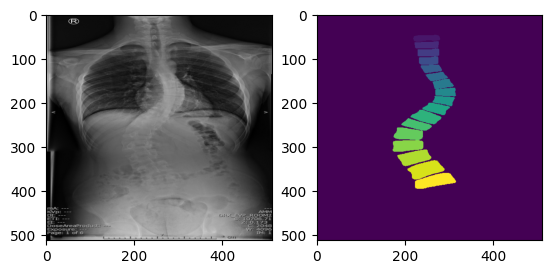

In [5]:
img, mask = fn.load_image_and_mask(coco, 2, img_dir)
print(img.shape)
print(mask.shape)
plt.subplot(1,2,1)
plt.imshow(img.squeeze(), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(mask)
plt.show()

In [6]:

train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=5, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=0, p=0.5),
    # A.RandomBrightnessContrast(p=0.3),
    # A.GaussianBlur(blur_limit=(3,5), p=0.3),
    A.Normalize(mean=(0.5,), std=(0.5,)),  # normaliza
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

/notebooks/venv/lib/python3.11/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


## preparando el pre entrenamiento 

In [7]:
import torchvision.transforms.v2 as v2
import torchvision.transforms.v2.functional as F

class SpineDataset(Dataset):
    def __init__(self, coco, img_dir, ids, transform=None, size=(512, 512)):
        self.coco = coco
        self.img_dir = img_dir
        self.ids = ids
        self.transform = transform
        self.size = size

    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img, mask = fn.load_image_and_mask(self.coco, img_id, self.img_dir, self.size) # -> (C, H, W), (H, W)

        # print(img.shape, mask.shape)
        
        # transponer img
        if img.ndim == 3 and img.shape[0] == 1:  
            img = np.transpose(img, (1, 2, 0))  # (C, H, W) → (H, W, C)
     
        img = img.astype("float32")
        mask = mask.astype("int64")


        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask'].long()
        else:
            img = img / 255.0 if img.max() > 1.0 else img
            img = torch.tensor(img, dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.long)

        return img, mask


    # def __getitem__(self, idx):
    #     img_id = self.ids[idx]
    #     img, mask = fn.load_image_and_mask(self.coco, img_id, self.img_dir, self.size)
        
    #     # normalize
    #     img = img / 255.0 if img.max() > 1.0 else img
     

    #     # convertir a tensores
    #     img = torch.tensor(img, dtype=torch.float32)
    #     mask = torch.tensor(mask, dtype=torch.long)


    #     # aplicar transformaciones

    #     if self.transform:
    #         img = self.transform(img)
         

    #     return img, mask

In [8]:
ids = list(coco.getImgIds())

# train 80%, val 10%, test 10%
train_ids, test_ids = train_test_split(ids, test_size=0.2, random_state=42)
val_ids, test_ids = train_test_split(test_ids, test_size=0.5, random_state=42)

In [9]:
size = (768, 768)
train_set = SpineDataset(coco, img_dir, train_ids, transform=train_transforms, size=size)
val_set = SpineDataset(coco, img_dir, val_ids, transform=val_transforms, size=size)
test_set = SpineDataset(coco, img_dir, test_ids, transform=val_transforms, size=size)

In [10]:
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
test_loader = DataLoader(test_set, batch_size=4, shuffle=False)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False)

In [11]:
# verificacion 

# imgs -> [Batch, Channels, Height, Width]
# masks -> [Batch, Height, Width]

imgs, masks = next(iter(train_loader))
print("imgs:", imgs.shape, imgs.dtype)
print("masks:", masks.shape, masks.dtype)

# unit test
assert imgs.shape == (4, 1, 768, 768)
assert masks.shape == (4, 768, 768)

print("imgs dtype:", imgs.dtype)
print("masks dtype:", masks.dtype)

imgs: torch.Size([4, 1, 768, 768]) torch.float32
masks: torch.Size([4, 768, 768]) torch.int64
imgs dtype: torch.float32
masks dtype: torch.int64


## Seleccioon del modelo


In [12]:
# os.environ["DISABLE_PROGRESS_BAR"] = "0"
# raise SystemExit
unet = smp.Unet(
    encoder_name="resnet50",    # Backbone
    encoder_weights="imagenet", # Pre-trained weights for encoder
    in_channels=1,              # Grayscale images
    classes=18                  # number of classes 17 vertebras + background
)

unetpp = smp.UnetPlusPlus(
    encoder_name="resnet34",    # Backbone
    encoder_weights="imagenet", # Pre-trained weights for encoder
    in_channels=1,              # Grayscale images
    classes=18                  # number of classes 17 vertebras + background
)

model = unet

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [134]:
# for imgs, masks in val_loader:
#     print("Batch:", imgs.shape)
#     imgs, masks = imgs.to(device), masks.to(device)
#     outputs = model(imgs)
#     break

In [15]:
# loss
# TODO: improve loss function
# loss_fn = smp.losses.DiceLoss(mode='multiclass')
dice_loss = smp.losses.DiceLoss(mode='multiclass')  # 👈 importante: especificar el modo
ce_loss = nn.CrossEntropyLoss()

loss_fn = lambda y_pred, y_true: 0.7 * dice_loss(y_pred, y_true) + 0.3 * ce_loss(y_pred, y_true)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# metrics
dice_metric = DiceScore(num_classes=18, average='macro', input_format="index").to(device)
iou_metric = MulticlassJaccardIndex(num_classes=18, average='macro').to(device)

## Training cicle

In [16]:
import torch, gc

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()



In [17]:
!nvidia-smi

Tue Oct 28 01:47:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A4000               On  |   00000000:00:05.0 Off |                  Off |
| 46%   58C    P2             42W /  140W |     167MiB /  16376MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [20]:
model.to(device)


EPOCHS = 2
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        img, masks = imgs.to(device), masks.to(device)
        
        optimizer.zero_grad()   # reset gradientes
        outputs = model(img)    # forward pass
        loss = loss_fn(outputs, masks)  # calcular loss
        loss.backward()         # backward pass
        optimizer.step()        # actualizar pesos
        train_loss += loss.item()

    # validacion
    model.eval()
    times = []
    n_samples = 1
    dice_metric.reset()
    iou_metric.reset()

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)

              # Sincronizar antes de medir (importante si usas GPU)
            torch.cuda.synchronize() if device.type == "cuda" else None
            start = time.time()

            outputs = model(imgs)

            # Sincronizar y medir tiempo
            torch.cuda.synchronize() if device.type == "cuda" else None
            end = time.time()

            # Calcular ms por imagen
            elapsed_ms = (end - start) * 1000 / imgs.size(0)
            times.append(elapsed_ms)

            preds = torch.argmax(outputs, dim=1)
            dice_metric.update(preds, masks)
            iou_metric.update(preds, masks)

    val_iou = iou_metric.compute().item()
    val_dice = dice_metric.compute().item()
    mean_infer_time = np.mean(times)

    print(f"Epoch {epoch+1}/{EPOCHS}, "
        f"Train Loss: {train_loss/len(train_loader):.4f}, "
        f"Val IoU: {val_iou:.4f}, "
        f"Val Dice: {val_dice:.4f}, "
        f"Mean Inference Time: {mean_infer_time:.2f} ms")


Epoch 1/2: 100%|██████████| 34/34 [00:19<00:00,  1.73it/s]


Epoch 1/2, Train Loss: 0.0890, Val IoU: 0.3782, Val Dice: 0.4626, Mean Inference Time: 22.47 ms


Epoch 2/2: 100%|██████████| 34/34 [00:19<00:00,  1.73it/s]


Epoch 2/2, Train Loss: 0.1002, Val IoU: 0.3694, Val Dice: 0.4618, Mean Inference Time: 22.52 ms


In [ ]:
# save the model 
# torch.save(model.state_dict(), "lastone.pth")


In [19]:
model.load_state_dict(torch.load("lastone.pth", map_location=device))

<All keys matched successfully>

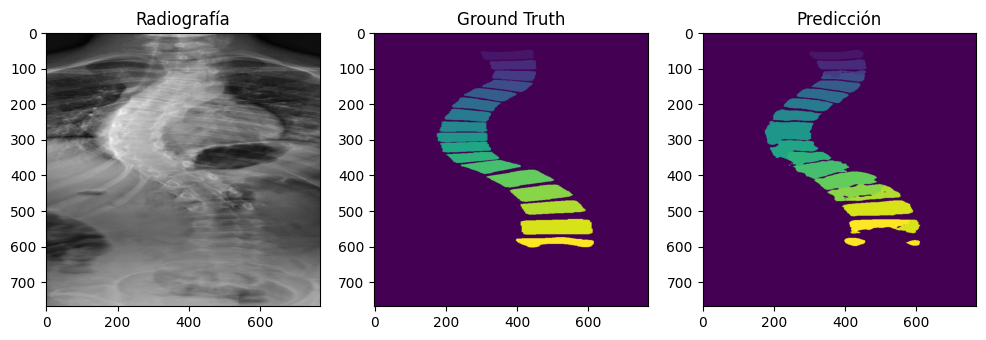

In [37]:
model.eval()
img, mask = val_set[4]

with torch.no_grad():
    pred = torch.argmax(model(img.unsqueeze(0).to(device)), dim=1).squeeze().cpu()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img.squeeze(), cmap='gray'); plt.title('Radiografía')
plt.subplot(1,3,2); plt.imshow(mask); plt.title('Ground Truth')
plt.subplot(1,3,3); plt.imshow(pred); plt.title('Predicción')
plt.show()

# Metricas

In [38]:
from torchmetrics.classification import MulticlassJaccardIndex
# from torchmetrics.classification import MulticlassDice
from torchmetrics.segmentation  import DiceScore

num_classes = 18  # 17 vértebras + fondo

dice_metric = DiceScore(num_classes=num_classes, average=None, input_format="index").to(device)
iou_metric = MulticlassJaccardIndex(num_classes=num_classes, average=None).to(device)

model.eval()
all_preds, all_masks = [], []

with torch.no_grad():
    for i, (imgs, masks) in enumerate(val_loader):
        print(i)
        imgs, masks = imgs.to(device), masks.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds)
        all_masks.append(masks)


# concatenar todos los batches
preds = torch.cat(all_preds)
masks = torch.cat(all_masks)

iou_per_class = iou_metric(preds, masks).cpu().numpy()
dice_per_class = dice_metric(preds, masks).cpu().numpy()

labels = ["bg","T1","T2","T3","T4","T5","T6","T7","T8","T9","T10","T11","T12","L1","L2","L3","L4","L5"]



print("iou_per_class shape:", iou_per_class.shape)
print("dice_per_class shape:", dice_per_class.shape)
print("labels len:", len(labels))

mean_iou = iou_per_class.mean()
mean_dice = dice_per_class.mean()

df = pd.DataFrame({
    "Clase": labels,
    "IoU": iou_per_class,
    "Dice": dice_per_class
})
# add mean row
df.loc[len(df)] = ["mean", mean_iou, mean_dice]
df = df.round(4)
print(df)


0
1
2
3
4
iou_per_class shape: (18,)
dice_per_class shape: (18,)
labels len: 18
   Clase     IoU    Dice
0     bg  0.9765  0.9879
1     T1  0.5522  0.6891
2     T2  0.4557  0.6063
3     T3  0.3678  0.5186
4     T4  0.3480  0.4959
5     T5  0.3596  0.5287
6     T6  0.3351  0.4907
7     T7  0.3040  0.3987
8     T8  0.2153  0.2647
9     T9  0.2326  0.3188
10   T10  0.2797  0.3814
11   T11  0.2657  0.3642
12   T12  0.3291  0.4139
13    L1  0.3763  0.4769
14    L2  0.3549  0.4393
15    L3  0.3356  0.4733
16    L4  0.3444  0.5022
17    L5  0.2598  0.4432
18  mean  0.3718  0.4885


In [39]:
from torchmetrics import ConfusionMatrix

confmat = ConfusionMatrix(task="multiclass", num_classes=18).to(device)

model.eval()
with torch.no_grad():
    for imgs, masks in val_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        
        confmat.update(preds, masks)

cm = confmat.compute().cpu().numpy()
# print(cm)

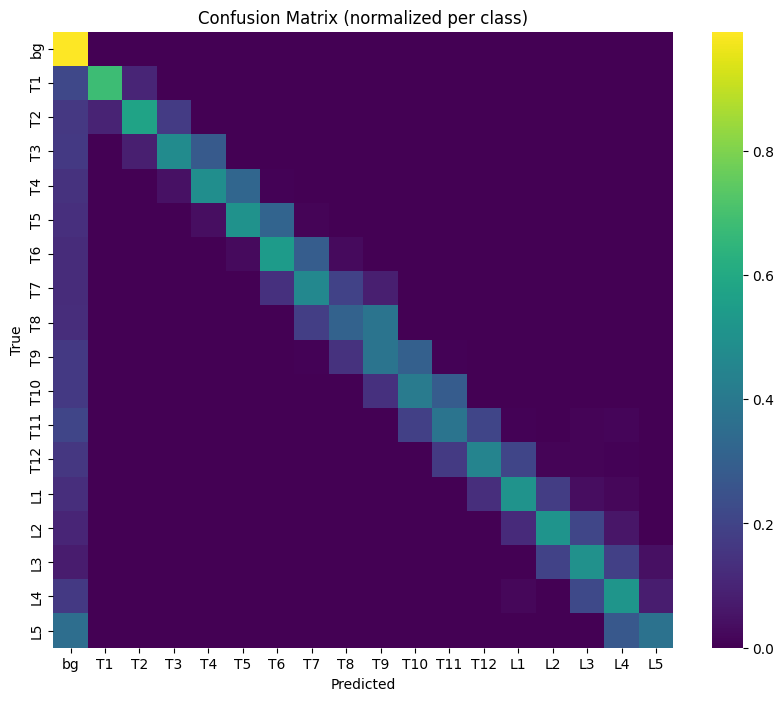

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

labels = ["bg","T1","T2","T3","T4","T5","T6","T7","T8","T9","T10","T11","T12","L1","L2","L3","L4","L5"]

plt.figure(figsize=(10,8))
sns.heatmap(cm / np.sum(cm, axis=1, keepdims=True), 
            xticklabels=labels, 
            yticklabels=labels, 
            cmap='viridis',
            annot=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (normalized per class)")
plt.show()

In [40]:

def overlay_mask(image, mask, alpha=0.5, num_classes=18):
   if isinstance(image, torch.Tensor):
       image = image.squeeze().cpu().numpy()

   image = (image - image.min()) / (image.max() - image.min())
   cmap = plt.get_cmap('tab20', num_classes)
   color_mask = cmap(mask.cpu().numpy() / num_classes)[..., :3]  
   
   overlay = (1 - alpha) * np.stack([image]*3, axis=-1) + alpha * color_mask
   return overlay

   

   

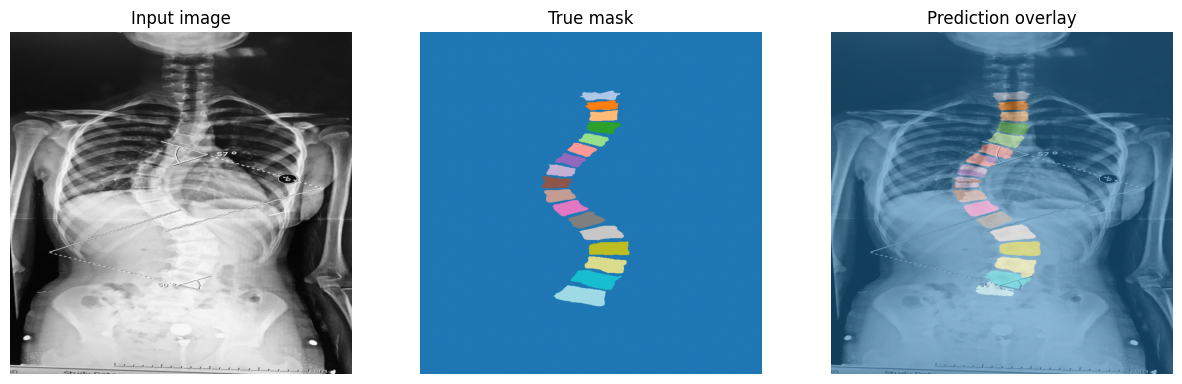

In [41]:
# obtener un batch
imgs, masks = next(iter(val_loader))

img = imgs[1].unsqueeze(0).to(device)
mask_true = masks[1].cpu().numpy()

# obtener prediccion

with torch.no_grad():
    output = model(img) # [1, 18, H, W]
    pred_mask = torch.argmax(output, dim=1).squeeze()


overlay = overlay_mask(img, pred_mask, alpha=0.5, num_classes=18)

labels = ["bg","T1","T2","T3","T4","T5","T6","T7","T8","T9","T10","T11","T12","L1","L2","L3","L4","L5"]


plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("Input image")
plt.imshow(img.squeeze().cpu(), cmap='gray')
plt.axis("off")

plt.subplot(1,3,2)
plt.title("True mask")
plt.imshow(mask_true, cmap='tab20', vmin=0, vmax=17)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Prediction overlay")
plt.imshow(overlay)
plt.axis("off")

plt.show()

/tmp/ipykernel_43/1756982185.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(categories))


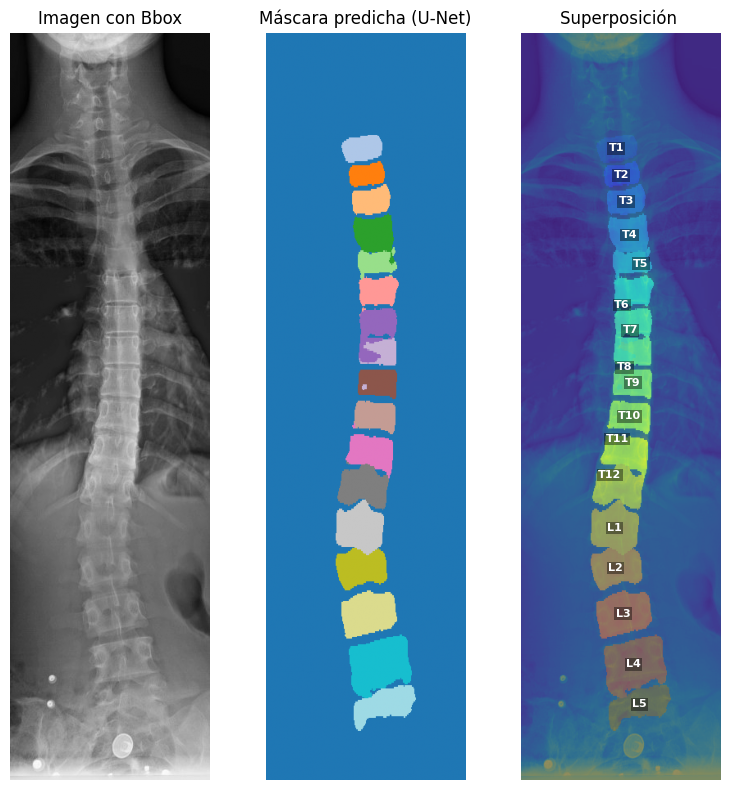

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, center_of_mass

# --- Seleccionar imagen del dataset ---
img_info = data['images'][1]
img_path = os.path.join(img_dir, img_info['file_name'])


# --- Cargar imagen y máscara ---
img_np = np.array(Image.open(img_path).convert('L'))

img,mask = fn.load_image_and_mask(coco, img_info['id'], img_dir)

# Normalizar igual que en tu dataset
img = img / 255.0
img = torch.tensor(img, dtype=torch.float32)


img = img.unsqueeze(0)
img = img.to(device)

# img -> [C, H, W]

model.eval()
with torch.no_grad():

    # model expects [B, C, H, W]
    output = model(img)
    pred_mask = torch.argmax(output, dim=1) # [B, H, W]

orig_w, orig_h = img_info['width'], img_info['height']
mask_np = pred_mask.squeeze().cpu().numpy()
mask_resized = cv2.resize(mask_np, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)


# ---- crear mapa de colores por categoría ----
categories = data['categories']
cmap = plt.cm.get_cmap('tab20', len(categories))
category_colors = {cat['id']: cmap(i) for i, cat in enumerate(categories)}



# ---- Obtener anotaciones de la imagen ----
annots = [a for a in data['annotations'] if a['image_id'] == img_info['id']]

# ---- Visualizar imagen con anotaciones ----

fig, axes = plt.subplots(1, 3, figsize=(8, 8))

# -------------------------------------------------
# 1️⃣ Imagen 
# -------------------------------------------------
axes[0].imshow(img_np, cmap='gray')
axes[0].set_title('Imagen con Bbox')
axes[0].axis('off')


# -------------------------------------------------
# 2️⃣ Máscara segmentada
# -------------------------------------------------

axes[1].imshow(mask_resized, cmap='tab20')
axes[1].set_title('Máscara predicha (U-Net)')
axes[1].axis('off')

# -------------------------------------------------
# 2️⃣ labels
# -------------------------------------------------

# --- Obtener clases únicas (sin incluir fondo 0) ---
unique_classes = np.unique(mask_resized)
unique_classes = unique_classes[unique_classes != 0]  # quitar fondo

# --- Generar labels según tu orden ---
labels = ["bg","T1","T2","T3","T4","T5","T6","T7","T8","T9",
          "T10","T11","T12","L1","L2","L3","L4","L5"]

# --- Crear copia para mostrar ---
mask_with_labels = cv2.cvtColor((mask_resized * (255 / mask_resized.max())).astype(np.uint8), cv2.COLOR_GRAY2BGR)



# -------------------------------------------------
# 3️⃣ Superposición máscara + imagen
# -------------------------------------------------
axes[2].imshow(img_np, alpha=0.8)
axes[2].imshow(mask_resized, cmap='jet', alpha=0.4)
axes[2].set_title('Superposición ')
axes[2].axis('off')


# --- Calcular centroides (una sola etiqueta por clase) ---
for cls in unique_classes:
    binary_mask = (mask_resized == cls).astype(np.uint8)
    labeled, n = label(binary_mask)
    centers = center_of_mass(binary_mask, labeled, range(1, n+1))

    if len(centers) > 0:
        # Calcular centro promedio si hay varios fragmentos
        cy = np.mean([c[0] for c in centers])
        cx = np.mean([c[1] for c in centers])

        # Obtener color desde el colormap
        color = np.array(cmap(int(cls)))[:3]
        color_rgb = tuple(color)

        # Nombre de la clase
        name = labels[int(cls)] if int(cls) < len(labels) else f"C{int(cls)}"

        # Dibujar texto en axes[2]
        axes[2].text(
            int(cx), int(cy),
            name,
            color='white',
            fontsize=8,
            fontweight='bold',
            ha='center',
            va='center',
            bbox=dict(facecolor='black', alpha=0.4, edgecolor='none', pad=1)
        )


plt.tight_layout()
plt.show()
